# 서울시 지하철 유동인구 예측 (LSTM + RMSE 평가 포함)
- CARD_SUBWAY_MONTH_202503.csv 기반 일별 총 유동인구 예측
- LSTM 모델 구성 및 학습
- RMSE로 모델 성능 평가
- 예측 결과 시각화

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 데이터 로드
df = pd.read_csv('CARD_SUBWAY_MONTH_202503.csv', encoding='utf-8-sig')
df['사용일자'] = pd.to_datetime(df['사용일자'], format='%Y%m%d')
df_grouped = df.groupby('사용일자')[['승차총승객수', '하차총승객수']].sum().reset_index()
df_grouped['total'] = df_grouped['승차총승객수'] + df_grouped['하차총승객수']

In [24]:
# 정규화 및 시퀀스 구성
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_grouped[['total']])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 5
X, y = create_sequences(scaled, seq_length)

# 학습/테스트 분리
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [26]:
# LSTM 모델 구성 및 학습
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=50, batch_size=4, verbose=0)

C:\Users\gunho\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
# 예측 및 RMSE 계산
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f'LSTM 예측 RMSE: {rmse:.2f}명')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
LSTM 예측 RMSE: 2217972.02명


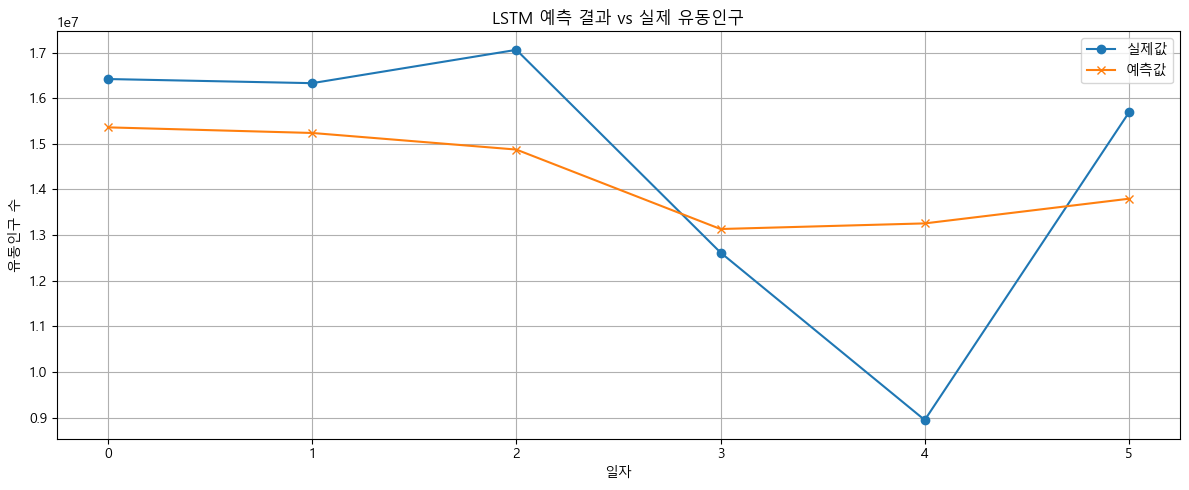

In [30]:
# 예측 시각화
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='실제값', marker='o')
plt.plot(y_pred_inv, label='예측값', marker='x')
plt.title('LSTM 예측 결과 vs 실제 유동인구')
plt.xlabel('일자')
plt.ylabel('유동인구 수')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()